In [68]:
!pip install xgboost lightgbm



In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('/content/Telco customer churn.csv')

# Step 3: Explore the Data
print("Dataset Info:")
print(df.info())
print("\nSample Rows:")
display(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [70]:
# Step 4: Data Cleaning and Preprocessing
# Convert 'TotalCharges' to numeric, set invalid to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Drop customerID as it's not useful for modeling
df = df.drop('customerID', axis=1)

# Encode binary columns
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Ensure 'SeniorCitizen' is int
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# One-hot encode other categoricals
categorical_cols = ['PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Check cleaned data
print("\nCleaned Data Info:")
print(df.info())
display(df.head())


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int64  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   tenure                                 7032 non-null   int64  
 5   PaperlessBilling                       7032 non-null   int64  
 6   MonthlyCharges                         7032 non-null   float64
 7   TotalCharges                           7032 non-null   float64
 8   Churn                                  7032 non-null   int64  
 9   PhoneService_Yes                       7032 non-null   bool   
 10  MultipleLines_No phone service         7032 non-null   bo

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,42.30,1840.75,0,False,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,70.70,151.65,1,True,...,False,False,False,False,False,False,False,False,True,False


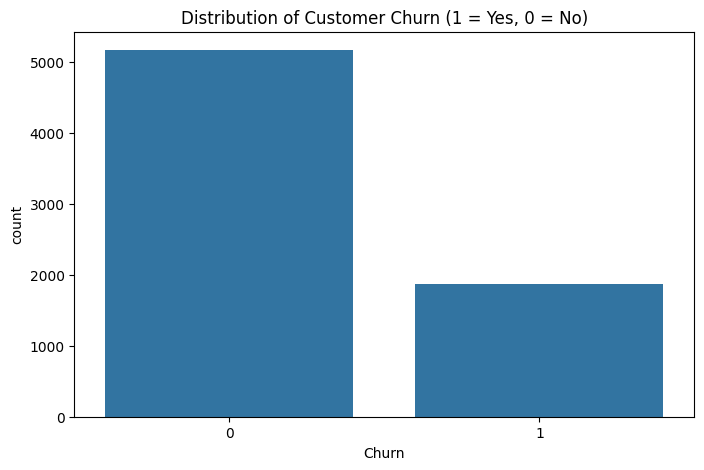


Churn Rate: 26.58%


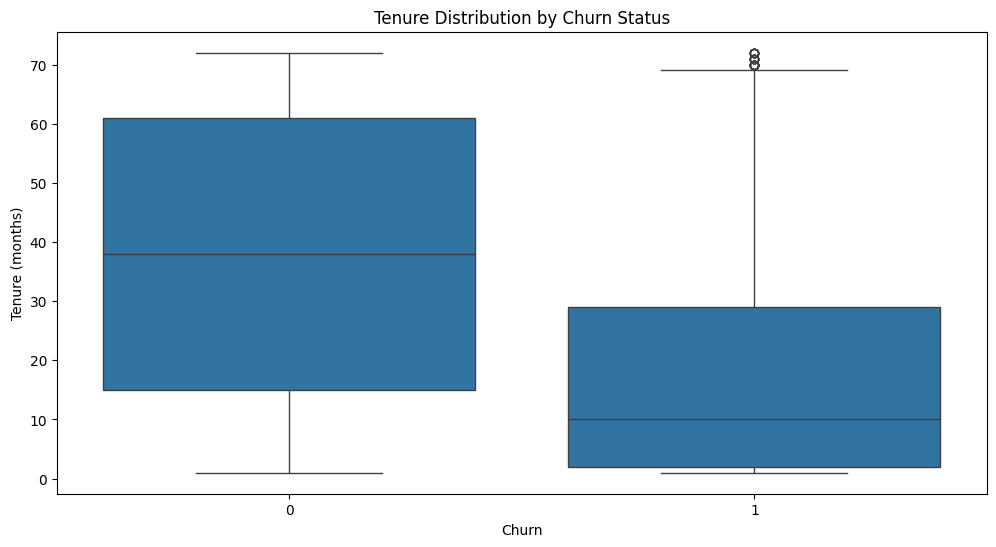

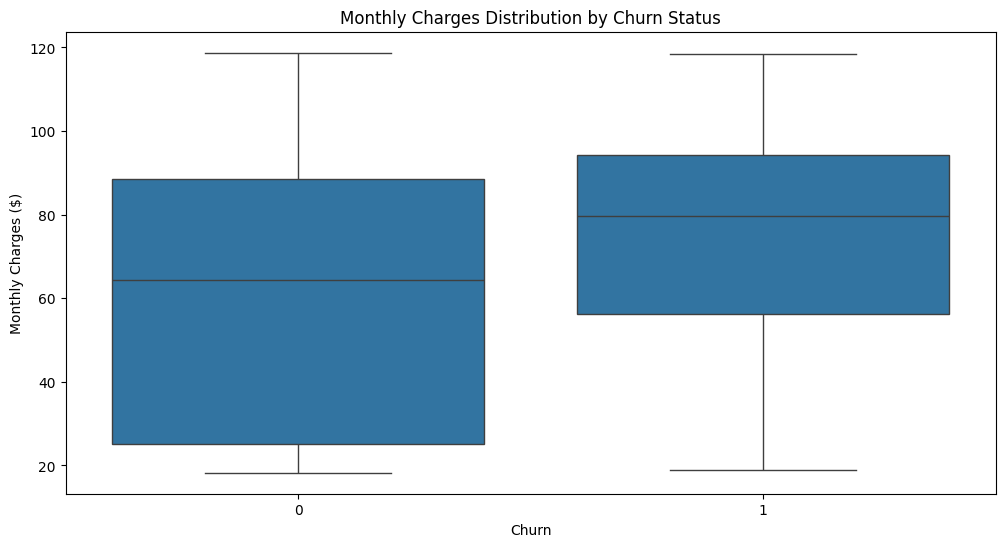

In [71]:
# Step 5: Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn (1 = Yes, 0 = No)')
plt.show()

# Churn rate
churn_rate = df['Churn'].mean()
print(f"\nChurn Rate: {churn_rate:.2%}")

# Example: Analyze tenure vs. churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure Distribution by Churn Status')
plt.ylabel('Tenure (months)')
plt.show()

# Example: Analyze monthly charges vs. churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges Distribution by Churn Status')
plt.ylabel('Monthly Charges ($)')
plt.show()

In [72]:
# Step 6: Prepare Data for Modeling
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

📊 Model Evaluation Metrics:
Accuracy  : 0.78
Precision : 0.63
Recall    : 0.45
F1 Score  : 0.53

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.63      0.45      0.53       374

    accuracy                           0.78      1407
   macro avg       0.73      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



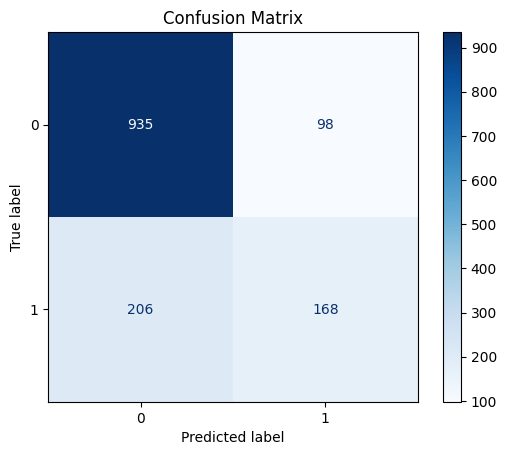

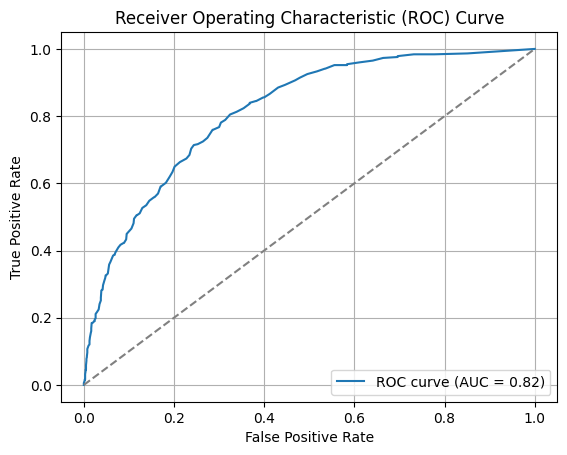

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC

# Print basic metrics
print("📊 Model Evaluation Metrics:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision : {precision_score(y_test, y_pred):.2f}")
print(f"Recall    : {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score  : {f1_score(y_test, y_pred):.2f}")

# Print classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Accuracy: 0.7839374555792467

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.63      0.45      0.53       374

    accuracy                           0.78      1407
   macro avg       0.73      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



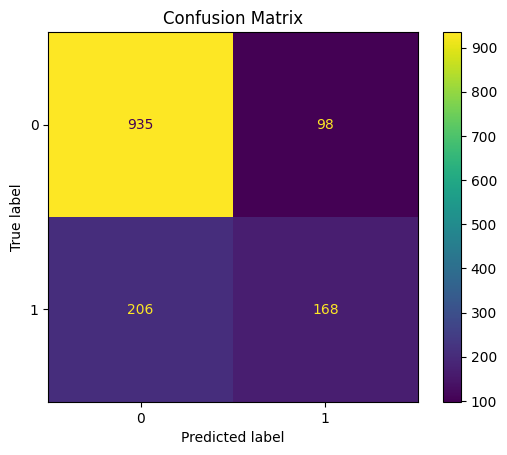

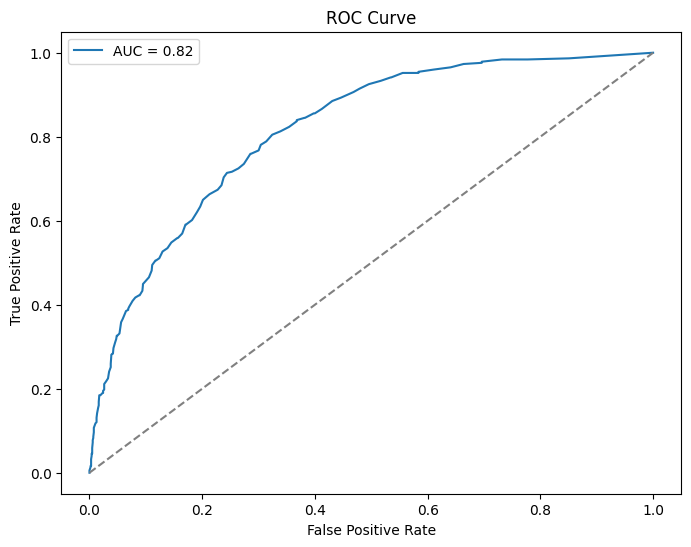

In [74]:
# Step 8: Evaluate the Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

📊 Churn Rate per Cluster:

Churn           0         1  Churn Rate (%)
Cluster                                    
0        0.832957  0.167043               0
1        0.575613  0.424387               0
2        0.946295  0.053705               0


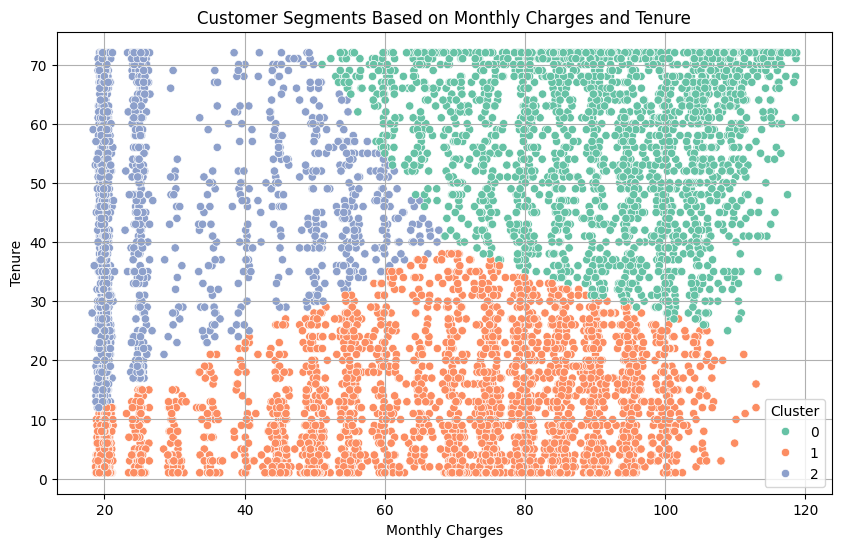

In [75]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for clustering
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_cluster = df[cluster_features].copy()

# Handle missing or non-numeric values in TotalCharges
X_cluster['TotalCharges'] = pd.to_numeric(X_cluster['TotalCharges'], errors='coerce')
X_cluster = X_cluster.dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)
X_cluster['Cluster'] = clusters

# Add back churn information
X_cluster['Churn'] = df.loc[X_cluster.index, 'Churn']

# Churn rate per cluster
cluster_summary = X_cluster.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack().fillna(0)
cluster_summary['Churn Rate (%)'] = cluster_summary.get('Yes', 0) * 100
print("📊 Churn Rate per Cluster:\n")
print(cluster_summary)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='tenure', hue='Cluster', data=X_cluster, palette='Set2')
plt.title('Customer Segments Based on Monthly Charges and Tenure')
plt.xlabel('Monthly Charges')
plt.ylabel('Tenure')
plt.grid(True)
plt.show()

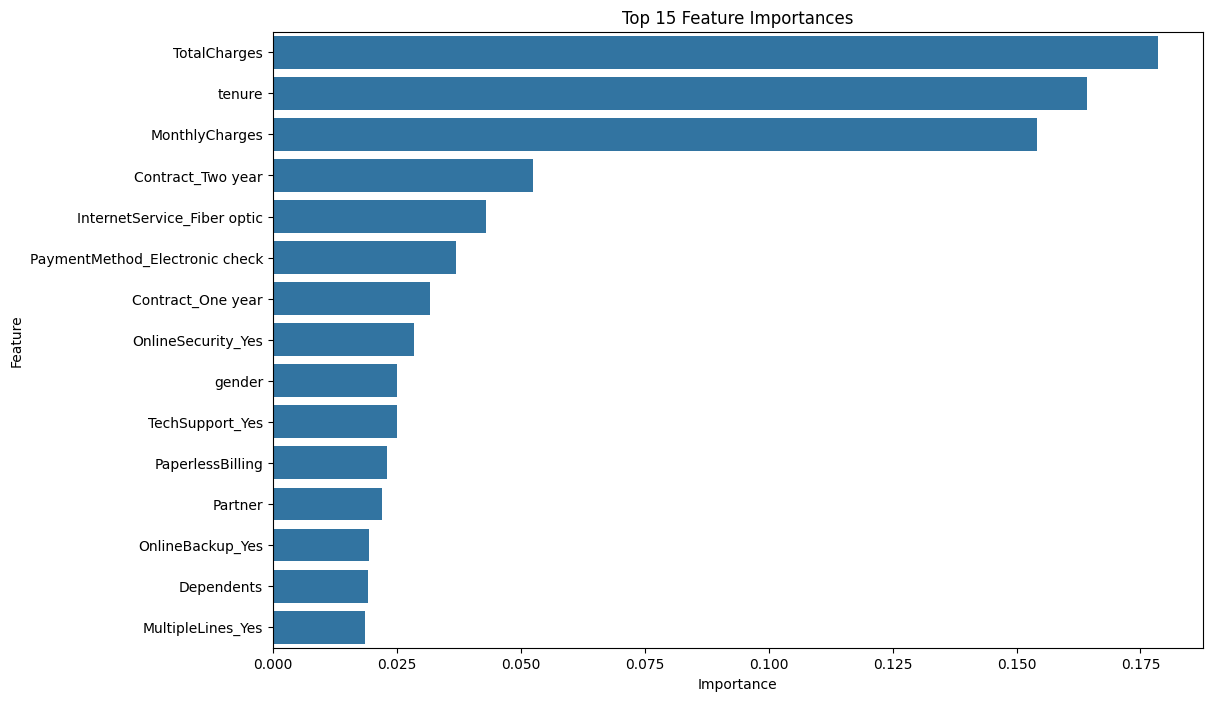

In [76]:
# Step 9: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

In [77]:
import joblib
joblib.dump(model, 'churn_model.pkl')

model = joblib.load('churn_model.pkl')